In [1]:
#Importing packages
from transformers import ViTModel, ViTImageProcessor
import torch
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import numpy as np

#Import library code
import dataloading
import data_vis

c:\Users\Aneesh\anaconda3\envs\vision_models\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(1234)

In [7]:
labels_csv = "camera_data/coronado_hills_binary_10-18-25.csv"
image_dir = "camera_data/images/"

data = dataloading.get_data(labels_csv=labels_csv, image_dir=image_dir)

In [8]:
train, val, test = dataloading.get_train_val_test(data = data, output_csvs=True)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
train_dataset, val_dataset, test_dataset = dataloading.get_datasets(train, val, test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, pin_memory=True)

In [ ]:
# Importing the model and setting the device. Using a ViT model since transformer architecture is generally pretty powerful when it comes to extracting features from data.
model_name = "google/vit-base-patch16-224"
vit = ViTModel.from_pretrained(model_name, torch_dtype=torch.float32)
device = "cuda" #Change to cpu if you aren't using a GPU

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class ViTEmbeddingNet(nn.Module):
    def __init__(self, vit_model):
        super().__init__()
        self.vit = vit_model

    def forward(self, pixel_values: torch.FloatTensor,labels: torch.LongTensor = None):
        outputs = self.vit(pixel_values)
        # Use [CLS] token (first token in the sequence) as embedding
        return outputs.last_hidden_state[:, 0]
    
encoder = ViTEmbeddingNet(vit)
encoder.to(device);

In [ ]:
encoder.load_state_dict(torch.load('weights/model_weights_camera_10-27-25.pth', weights_only=True))
encoder.eval();

In [ ]:
#Get embeddings of the first batch of data
batch = next(iter(val_dataloader))

images = batch['pixel_values'].to(device)
labels = batch['labels']

embedding = encoder(images)

In [ ]:
#Use PCA to reduce data to two dimensions so that we can visualize them 
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)

reduced_embedding = pca_model.fit_transform(embedding.to("cpu").detach().numpy())

labels_np = labels.detach().numpy()

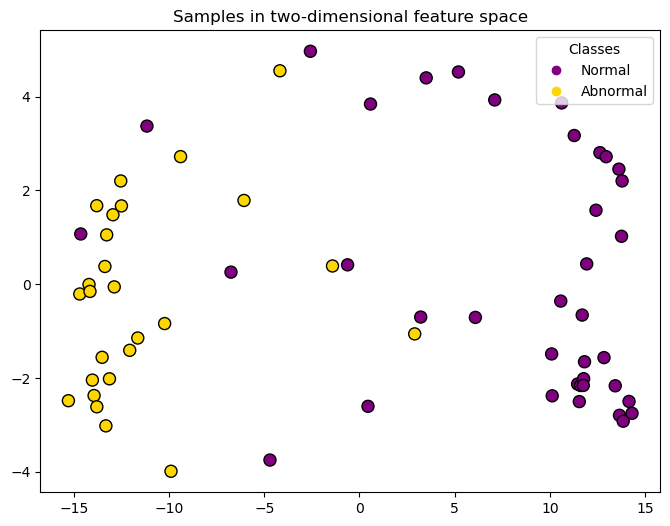

In [ ]:
data_vis.plot_data(reduced_embedding, labels_np)

Accuracy: 0.90625


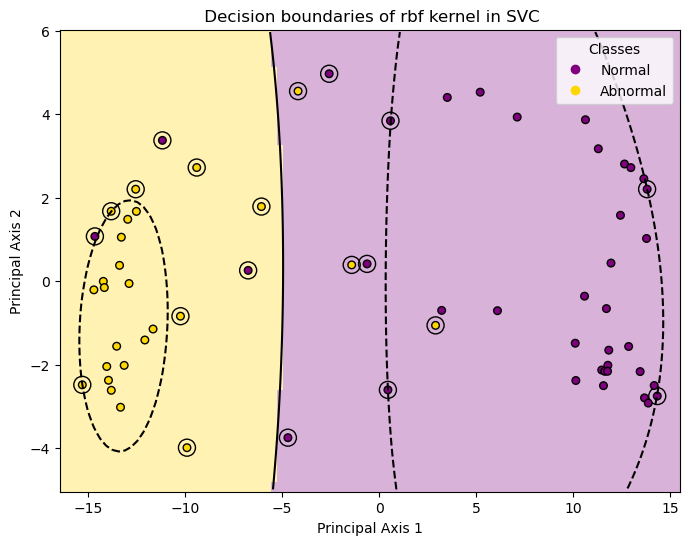

In [ ]:
svm_classifier = data_vis.plot_with_decision_boundary("rbf", reduced_embedding, labels_np)

In [5]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(
   svm_classifier, reduced_embedding, labels_np)

plt.show()

NameError: name 'svm_classifier' is not defined